# Udacity Behavior Cloning Project

In [1]:
# Keras model for cloning the driving behavior
# required libraries

%matplotlib inline
import matplotlib.pyplot as plt

import os
import argparse

import numpy as np
import pandas as pd

import cv2
import csv

import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten

Using TensorFlow backend.


# Constants

In [2]:
np.random.seed(0) # Set the random state to 0

# Location of the driving log
data_dir = 'data/mydata/'
driving_log = data_dir +'driving_log.csv'

# Nvidia end to end learning input image spec
rows, cols, ch = 66, 200, 3
nn_input_shape = ((rows, cols, ch))

# Set 20% of the entire dataset as validation
    test_split_ratio = 0.2

# Steering angle correction 
# used for left and right camera image augmentation
steering_angle_correction_factor = 0.2

# Image Preprocessing

In [3]:
def import_data(driving_log):
    '''
    Create training and validation dataset
    from the driving log
    '''
    samples = []
    with open(driving_log) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            steering_center = float(line[3])
            # create adjusted steering measurements for the side camera images
            correction = 0.2 # this is a parameter to tune
            steering_left = steering_center + correction
            steering_right = steering_center - correction
            
            samples.append(line)
    
    train_samples, validation_samples = train_test_split(samples, test_size=test_split_ratio)
    
    return train_samples, validation_samples

def load_image(img_path):
    '''
    Load RGB images from a file
    '''
    return mpimg.imread(img_path)

def crop(img):
    '''
    Crop out non-road sections of the image - the top (sky) and the bottom (engine cover)
    '''
    return img[60:-25,:,:]

def resize(img,width=cols,height=rows):
    '''
    Resize the image to the input shape used by the convolution neural network model
    '''
    return cv2.resize(img,(width,height),cv2.INTER_AREA)

def rgb2yuv(img):
    '''
    Convert the RGB image to YUV color space
    Y is the brightness channel
    '''
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def preprocess_image(img):
    '''
    Preprocess image pipeline
    '''
    img = crop(img)
    img = resize(img)
    img = rgb2yuv(img)
    return img

# Visualize the cropped resized image

(66, 200, 3)


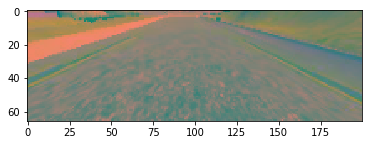

In [5]:
train_samples,validation_samples = import_data(driving_log)
img = load_image(train_samples[0][0])
processed_img = preprocess_image(img)
plt.imshow(processed_img)
print(processed_img.shape)

In [6]:
def modified_NVIDIA_Keras_model(verbose=False):
    '''
    Keras model apoted from Nivida's End to End Learning for Self-Driving Cars paper
    URL: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    '''
    
    rows, cols, ch = 66, 200, 3
    nn_input_shape = ((rows, cols, ch))
    
    model = Sequential()
    
    # Normalization layer 3@66x200
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=nn_input_shape))
    
    # 3 layers of 5x5 convolution (output depth 24, 36, and 48) each with 2x2 stride
    model.add(Conv2D(24,kernel_size=5, strides=(2, 2), padding='valid', activation='relu'))
    model.add(Conv2D(36,kernel_size=5, strides=(2, 2), padding='valid', activation='relu'))
    model.add(Conv2D(48,kernel_size=5, strides=(2, 2), padding='valid', activation='relu'))
    
    # 2 layers of 3x3 convolution (output depth 64, and 64)
    
    model.add(Conv2D(64,kernel_size=3, activation='relu'))
    model.add(Conv2D(64,kernel_size=3, activation='relu'))
    
    # Flatten convolution layer
    model.add(Flatten())
    
    # 3 layers of fully connected (depth 100, 50, 10)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    if verbose:
        # Show summary of the layers, output shapes and number of parameters
        model.summary()    

    return model

In [13]:
def batch_generator(samples, batch_size):
    '''
    The custom batch generator divide the data sample in batches and
    applies the image preprocessing (i.e. cropped,resize,RGB2YUV colorspace)
    '''
    
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # Center image and steering angle
                name = data_dir+'IMG/'+batch_sample[0].split('/')[-1]
                center_image = load_image(name)
                center_image = preprocess_image(center_image)
                center_angle = float(batch_sample[3])
                
                images.append(center_image)
                angles.append(center_angle)
                
                # Left image and steering angle (to be used later for augmentation)
                # name = data_dir+'IMG/'+batch_sample[1].split('/')[-1]
                # left_image = mpimg.imread(name)
                # left_image = preprocess_image(left_image)
                # left_angle = float(batch_sample[3]) + steering_angle_correction_factor

                # Right image and steering angle (to be used later for augmentation)
                # name = data_dir+'IMG/'+batch_sample[2].split('/')[-1]
                # right_image = mpimg.imread(name)
                # right_image = preprocess_image(right_image)
                # right_angle = float(batch_sample[3]) - steering_angle_correction_factor

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

def train_model(model,train_samples,validation_samples,save_model=True):
    '''
    Pipeline to feed the sample data (images and steering angles) in batches,
    train and save the Keras model
    '''
    
    '''
    verbose: Verbosity mode: 0, 1, or 2.
    0 = silent
    1 = progress bar
    2 = one line per epoch
    '''

    # Save the model weights after each epoch if the validation loss decreased
    checkpoint = ModelCheckpoint(filepath='checkpoint/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    
    # Early Stopping
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=2, 
    #               verbose=1, mode='auto', baseline=None, restore_best_weights=False)
    
    # Log the training progress
    # training log format: epoch, training loss, validation loss
    csv_logger = CSVLogger('log/training.log')

    batch_size = 64
    epochs = 5
    learning_rate = 1e-4
    
    # Compile the Keras model for training to predict the steering angles
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
    
    # Generate the "just in time" data in batches to feed to the model training pipeline
    # model.fit_generator()
    train_generator      = batch_generator(train_samples, batch_size=batch_size)
    validation_generator = batch_generator(validation_samples, batch_size=batch_size)
    
    # Train the model with the generated batched data
    training_history = model.fit_generator(train_generator,
                        steps_per_epoch = len(train_samples)//batch_size,
                        validation_data =  validation_generator,
                        validation_steps= len(validation_samples)//batch_size,
                        epochs=epochs, verbose=1,
                        max_queue_size=1,
                        callbacks=[checkpoint, csv_logger],
                        )

    # Save the Keras model for use to predict the steering angles later
    # with the drive.py
    if save_model:
        model.save('model.h5')
    
    return training_history

def plot_training_history(history_object):
    '''
    plot the training and validation loss for each epoch`
    
    '''
    
    print(history_object.history.keys())
    print(history_object.history)
    
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [11]:
# Import the sample data collected from the Udacity vehicle simulator
train_samples,validation_samples = import_data(driving_log)

# Build the modified Nvidia Keras model
model = modified_NVIDIA_Keras_model()

# Train the Keras model
history_object = train_model(model,train_samples,validation_samples)

Epoch 1/5
34/34 [==============================] - 11s 323ms/step - loss: 0.0215 - val_loss: 0.0137
Epoch 2/5
34/34 [==============================] - 10s 287ms/step - loss: 0.0173 - val_loss: 0.0117
Epoch 3/5
34/34 [==============================] - 10s 286ms/step - loss: 0.0153 - val_loss: 0.0108
Epoch 4/5
34/34 [==============================] - 10s 283ms/step - loss: 0.0140 - val_loss: 0.0106
Epoch 5/5
34/34 [==============================] - 10s 284ms/step - loss: 0.0132 - val_loss: 0.0099


dict_keys(['loss', 'val_loss'])
{'loss': [0.021486574414131397, 0.017388767242501272, 0.015335879911816565, 0.014056279588595172, 0.013205255265130061], 'val_loss': [0.013683242548722774, 0.011714701890014112, 0.010778659489005804, 0.010645368485711515, 0.0098934780107811093]}


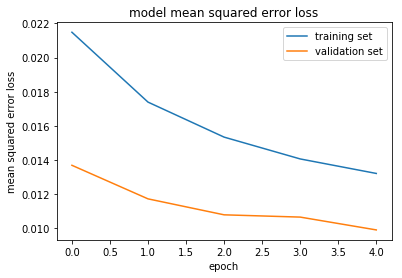

In [14]:
plot_training_history(history_object)